## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [1]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Random state seed
rseed = 42

## Load and explore data

In [3]:
# Import the dataset
country = pd.read_csv('Country-data.csv', index_col = 0)
country.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
# Check the shape
country.shape

(167, 9)

In [5]:
# Check datatypes & counts
print(country.dtypes)
print(country.count())

child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object
child_mort    167
exports       167
health        167
imports       167
income        167
inflation     167
life_expec    167
total_fer     167
gdpp          167
dtype: int64


In [6]:
# Get descriptive statistics
country.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [7]:
# Identify any missing data
print(country.isnull())

                     child_mort  exports  health  imports  income  inflation  \
country                                                                        
Afghanistan               False    False   False    False   False      False   
Albania                   False    False   False    False   False      False   
Algeria                   False    False   False    False   False      False   
Angola                    False    False   False    False   False      False   
Antigua and Barbuda       False    False   False    False   False      False   
...                         ...      ...     ...      ...     ...        ...   
Vanuatu                   False    False   False    False   False      False   
Venezuela                 False    False   False    False   False      False   
Vietnam                   False    False   False    False   False      False   
Yemen                     False    False   False    False   False      False   
Zambia                    False    False

In [8]:
# Drop any non-numeric features (columns)
non_numeric = country.select_dtypes(include=['number']).columns
non_numeric

Index(['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

## Preprocessing and Feature Selection

In [9]:
country.corr() # creates the correlation matrix between all the features

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1.000000,-0.318093,-0.200402,-0.127211,-0.524315,0.288276,-0.886676,0.848478,-0.483032
exports,-0.318093,1.000000,-0.114408,0.737381,0.516784,-0.107294,0.316313,-0.320011,0.418725
health,-0.200402,-0.114408,1.000000,0.095717,0.129579,-0.255376,0.210692,-0.196674,0.345966
imports,-0.127211,0.737381,0.095717,1.000000,0.122406,-0.246994,0.054391,-0.159048,0.115498
income,-0.524315,0.516784,0.129579,0.122406,1.000000,-0.147756,0.611962,-0.501840,0.895571
inflation,0.288276,-0.107294,-0.255376,-0.246994,-0.147756,1.000000,-0.239705,0.316921,-0.221631
life_expec,-0.886676,0.316313,0.210692,0.054391,0.611962,-0.239705,1.000000,-0.760875,0.600089
total_fer,0.848478,-0.320011,-0.196674,-0.159048,-0.501840,0.316921,-0.760875,1.000000,-0.454910
gdpp,-0.483032,0.418725,0.345966,0.115498,0.895571,-0.221631,0.600089,-0.454910,1.000000


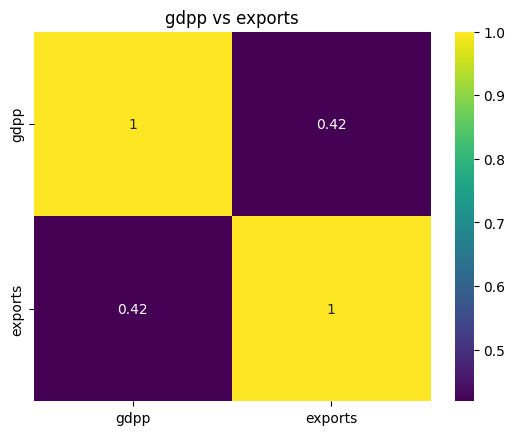

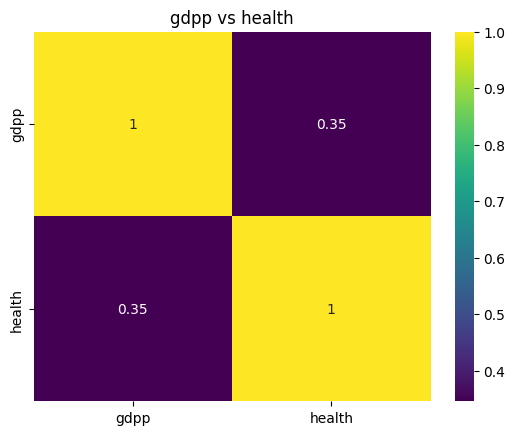

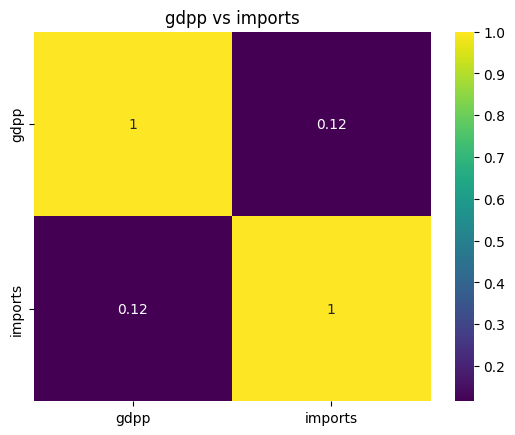

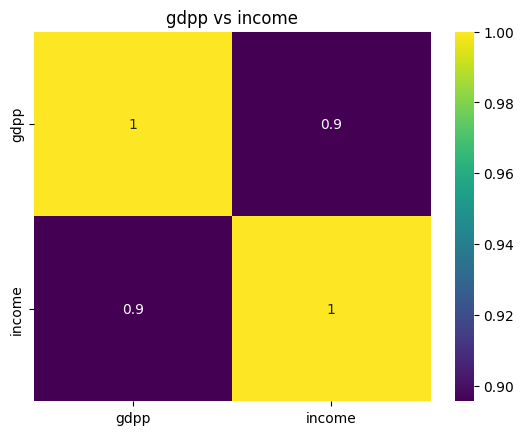

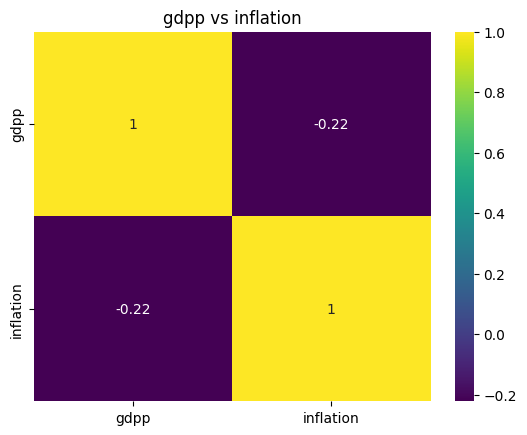

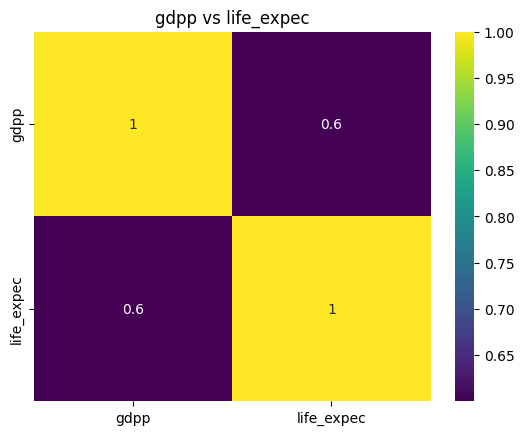

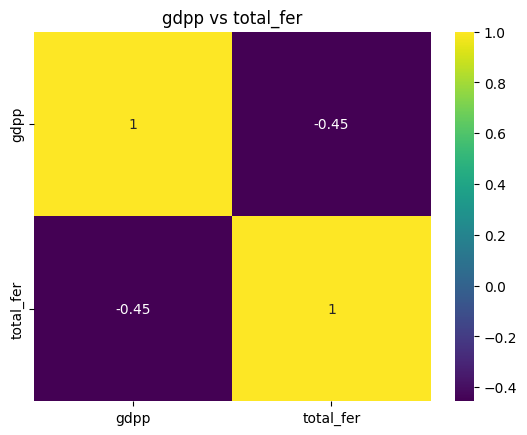

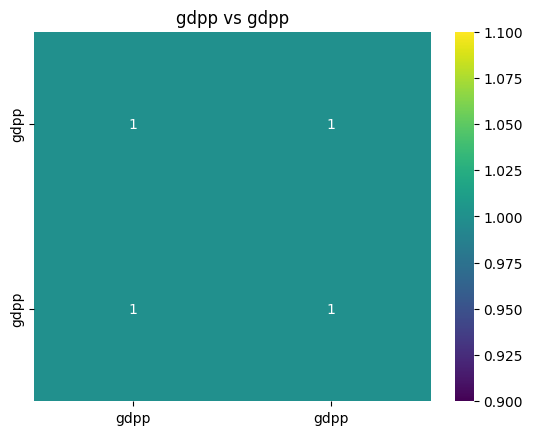

In [10]:
# Create 9 correlation maps of features to explore relationships between features
# Hint: Explore Seaborn heatmap
# This code provides a correlation between gdpp and the other column features in a form of a heatmap.

independent_features = ['exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
for i,  feature in enumerate (independent_features):
    features = country[['gdpp', feature]].corr()
    sns.heatmap(features, annot = True, cmap = 'viridis')
    plt.title(f'gdpp vs {feature}')
    plt.show()


Correlation Map between GDPP vs Exports look the most promising 

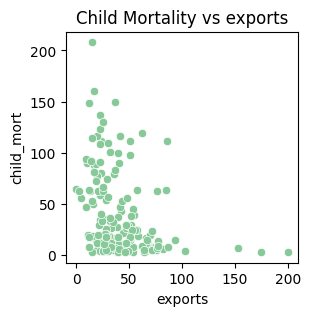

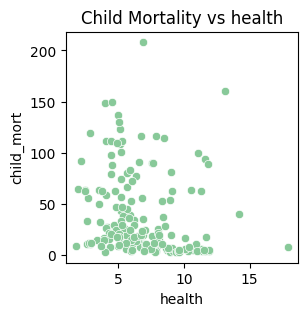

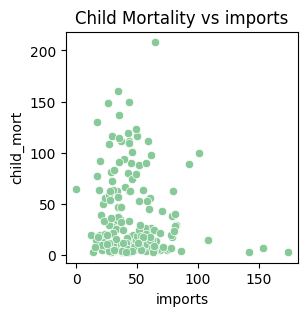

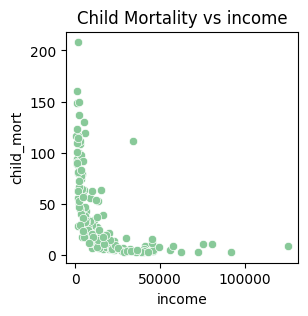

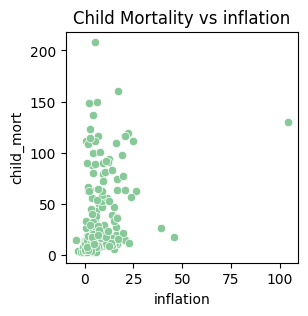

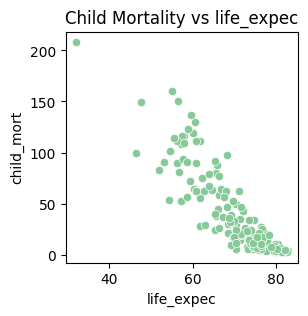

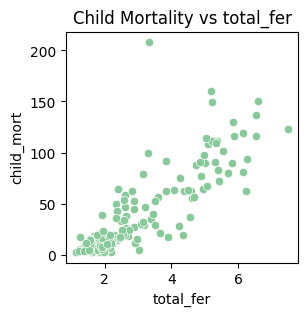

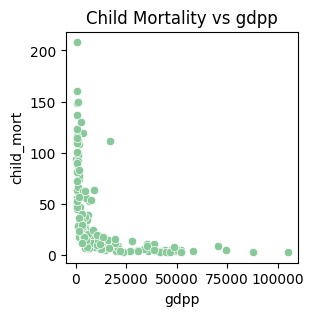

" 'sns.scatterplot(x = country[i], y = country['child_mort'], color = '#88c999')' this line creates\na scatterplot using the values in 'i' on the x-axis against the 'child_mort' column on the y-axis"

In [11]:
# Explore the continuous independent features against child_mort using scatter plots.
# This code presents a visualization relationship between child_mort and independent features.
# 'for i in independent_features:' loops features in the independent_features list

independent_features = ['exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
for i in independent_features:
   plt.figure(figsize=(3,3))
   sns.scatterplot(x = country[i], y = country['child_mort'], color = '#88c999')
   plt.title(f'Child Mortality vs {i}')
   plt.show()
    
''' 'sns.scatterplot(x = country[i], y = country['child_mort'], color = '#88c999')' this line creates
a scatterplot using the values in 'i' on the x-axis against the 'child_mort' column on the y-axis'''

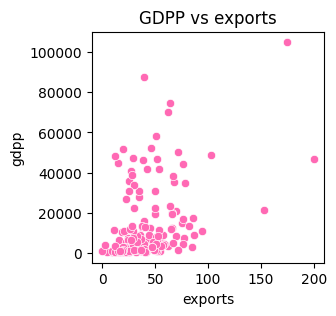

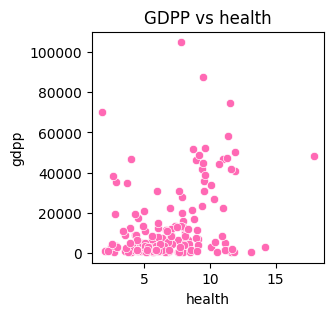

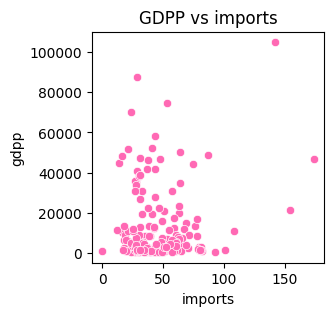

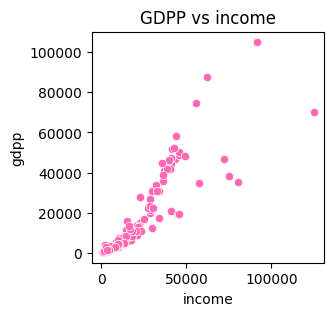

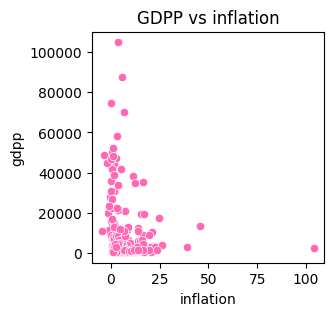

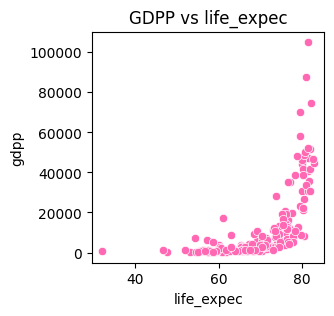

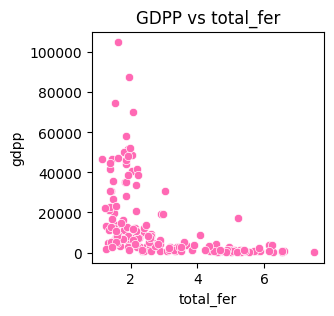

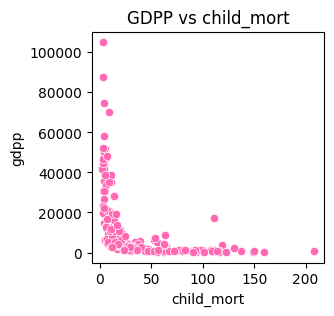

In [12]:
# Explore the continuous independent features against gdpp using scatter plots.

independent_features = ['exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'child_mort']
for i in independent_features:
   plt.figure(figsize=(3,3))
   sns.scatterplot(x = country[i], y = country['gdpp'], color = 'hotpink')
   plt.title(f'GDPP vs {i}')
   plt.show()

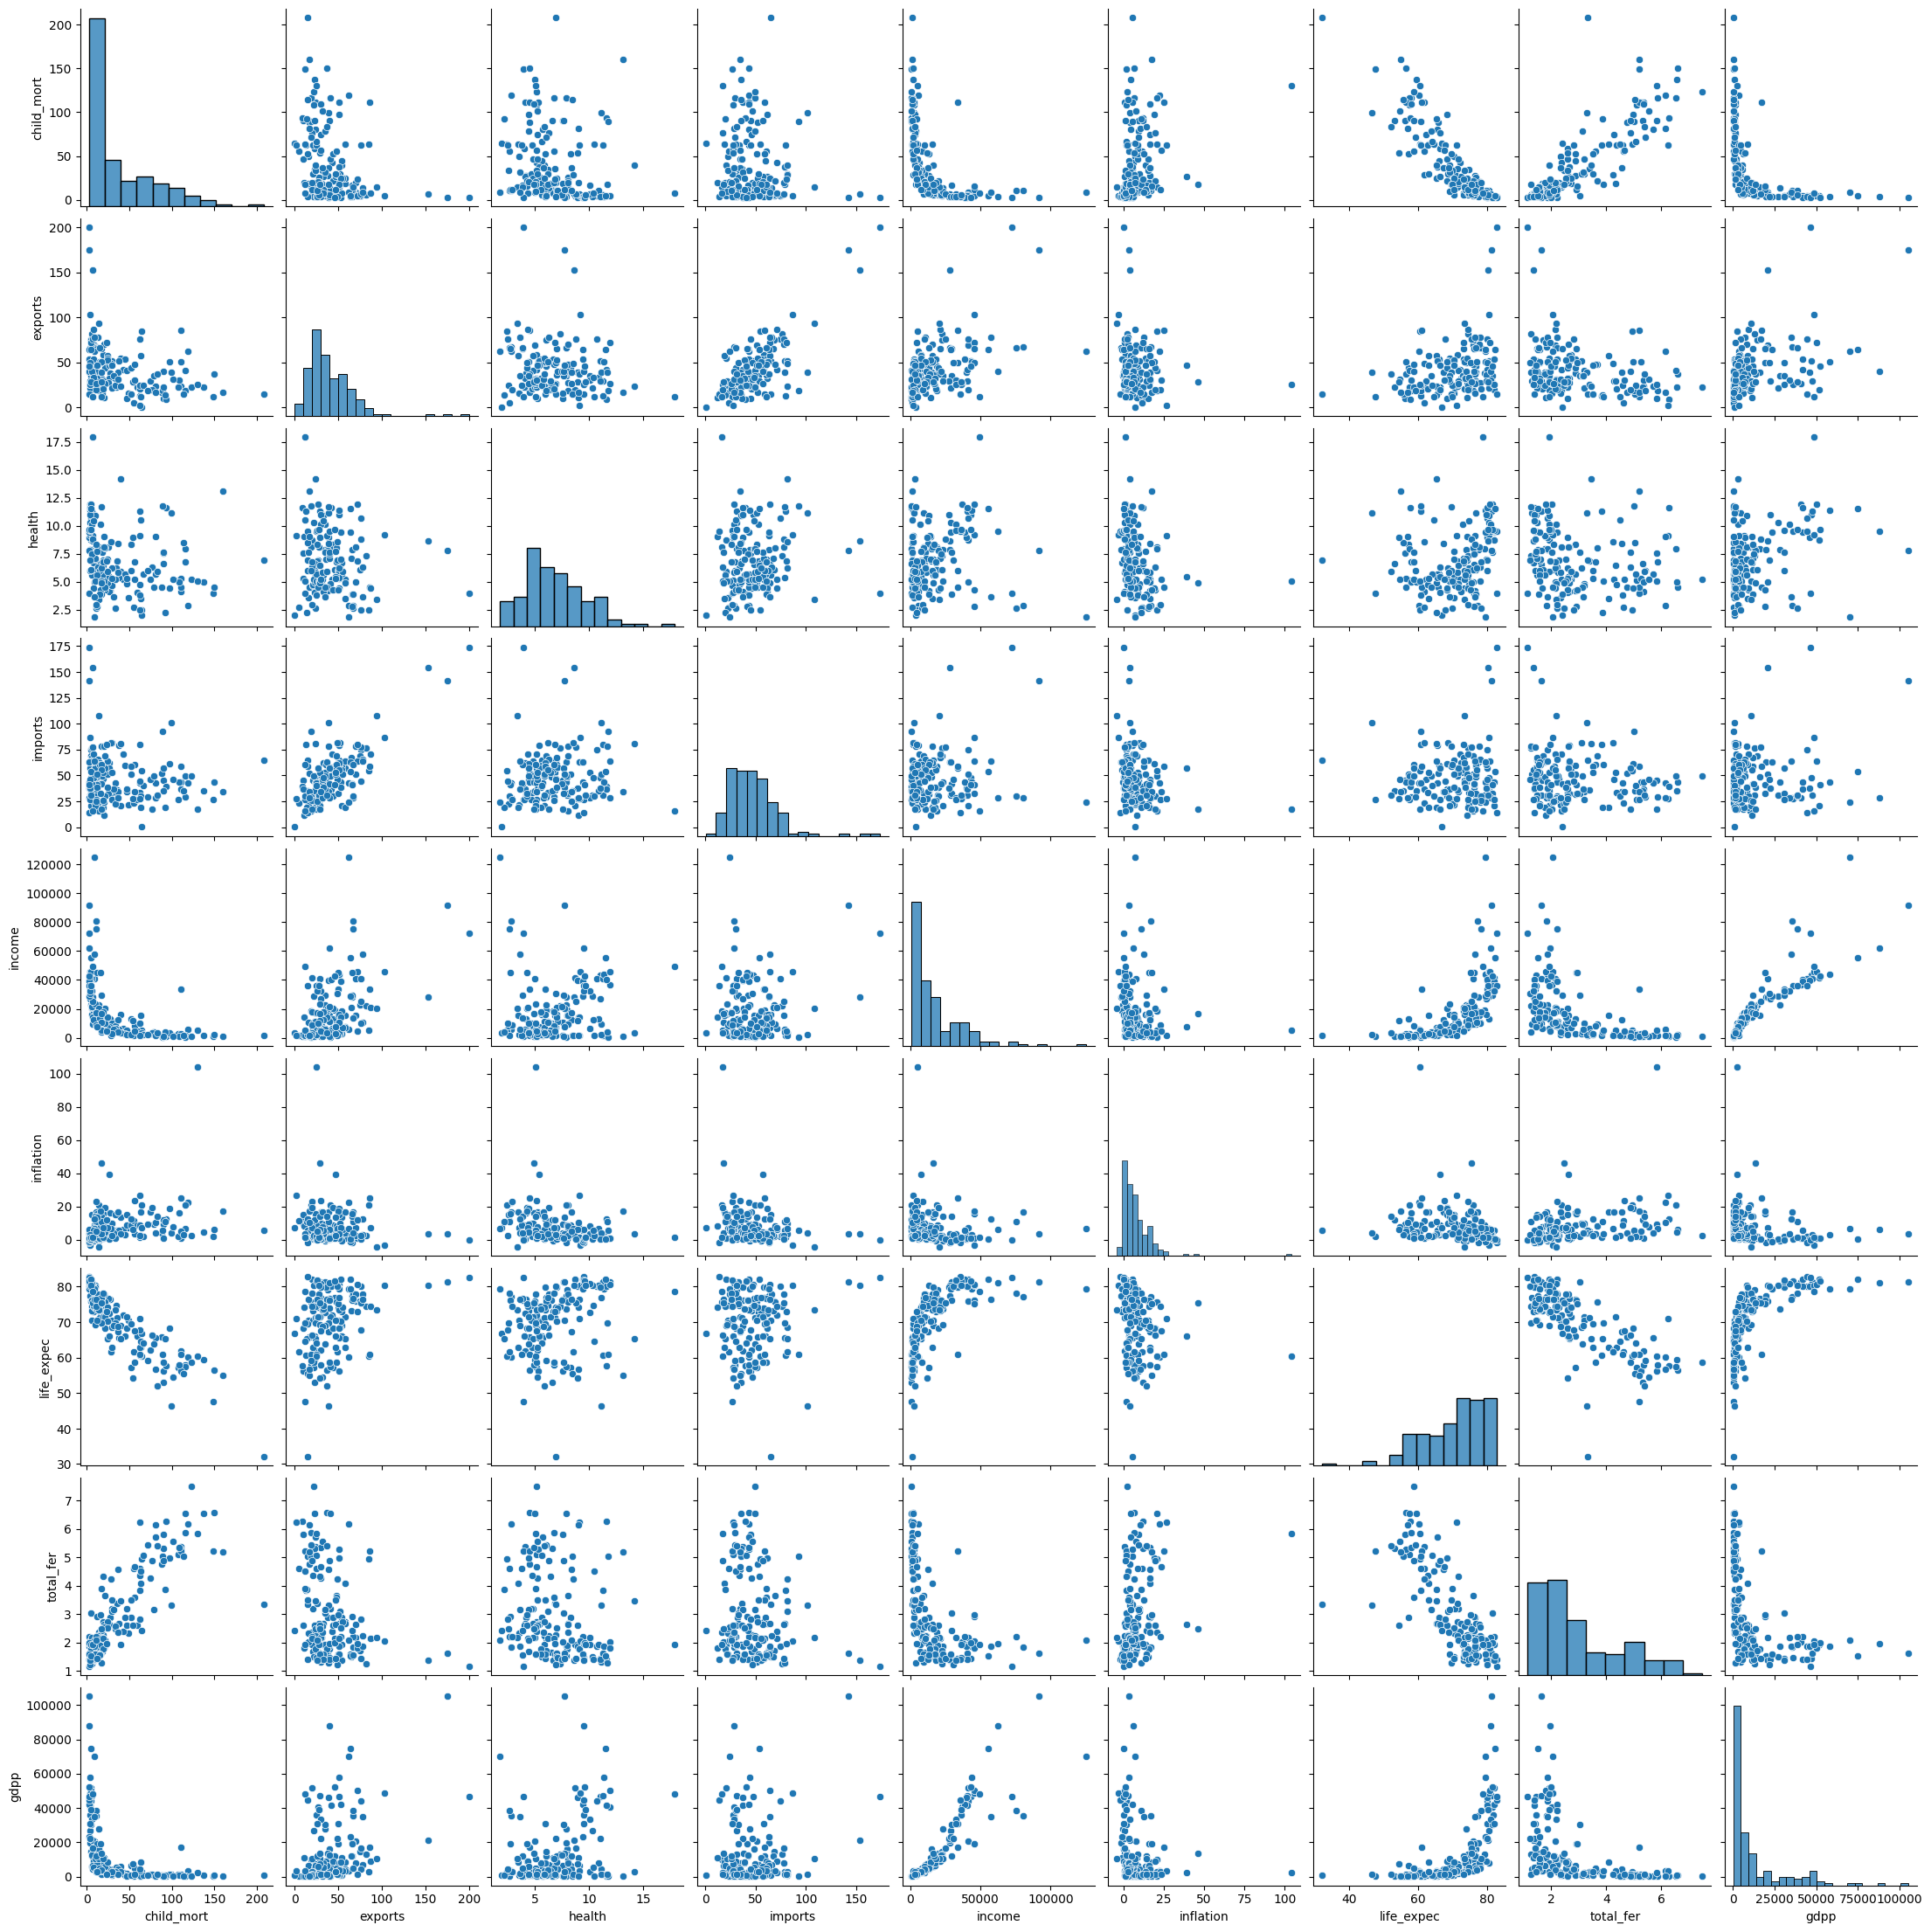

In [13]:
# Create a pair plot
# Hint: Explore seaborn pairplot
sns.pairplot(country)

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [14]:
# Normalise the data using MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(country.to_numpy()) # '.to_numpy() converts the dataframe into it NumPy

# Name the normalised dataframe "df_scaled"
df_scaled = pd.DataFrame(scaled_data, columns = non_numeric)

print(df_scaled.head())

   child_mort   exports    health   imports    income  inflation  life_expec  \
0    0.426485  0.049482  0.358608  0.257765  0.008047   0.126144    0.475345   
1    0.068160  0.139531  0.294593  0.279037  0.074933   0.080399    0.871795   
2    0.120253  0.191559  0.146675  0.180149  0.098809   0.187691    0.875740   
3    0.566699  0.311125  0.064636  0.246266  0.042535   0.245911    0.552268   
4    0.037488  0.227079  0.262275  0.338255  0.148652   0.052213    0.881657   

   total_fer      gdpp  
0   0.736593  0.003073  
1   0.078864  0.036833  
2   0.274448  0.040365  
3   0.790221  0.031488  
4   0.154574  0.114242  


## K-Means Clustering

### Selecting K

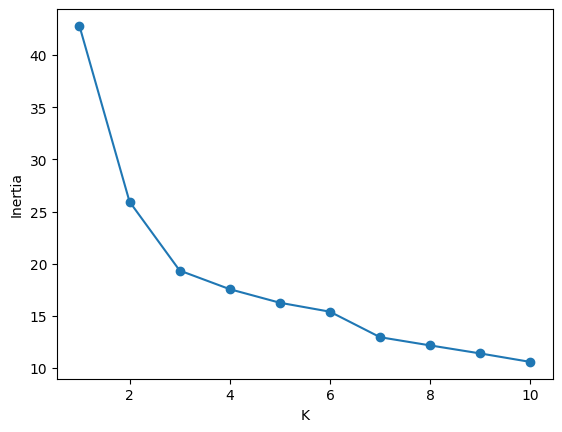

In [15]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

# Plot elbow curve using the scaled dataset
elbow_Kmeans(df_scaled, max_k=10, r=42)
# 'df_scaled' is used for the scaled data
# 'max_k=10' is used to the maximum number of clusters(K) when plotting
# 'r=42' is used for random state

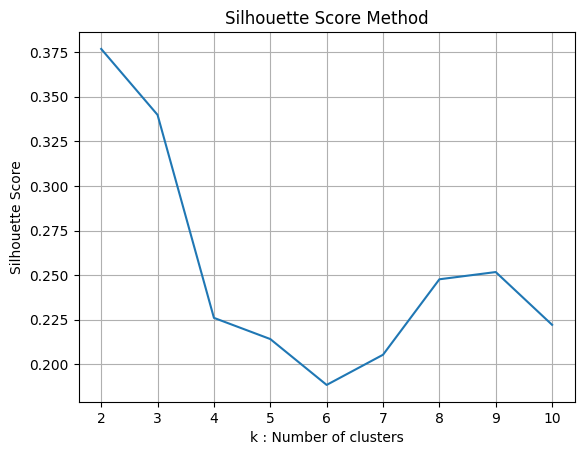

In [16]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Based on the elbow and silhouette score method choose a value for K.

## Fitting a K-Means Model with the selected K value

In [17]:
# Remember to set the random_state to rseed
kmeans = KMeans(n_clusters=3, random_state=rseed, max_iter=500)
label = kmeans.fit(df_scaled)

In [19]:
# Add cluster labels to the original DataFrame
country['Cluster'] = kmeans.labels_
# Count the number of records in each cluster 
# Using value_counts is used on the 'Cluster' column to count the number of records in each cluster
count_cluster = country['Cluster'].value_counts()
count_cluster

Cluster
0    87
2    45
1    35
Name: count, dtype: int64

In [20]:
# Check model performance with the silhouette coefficient
#'round' will round up the silhouette score by 5 
silhouette_coef = silhouette_score(df_scaled, labels)
print('Silhouette Score:', round (silhouette_coef, 5))

Silhouette Score: 0.22216


## Predictions

In [21]:
# Add the predicted cluster label column to the original dataframe
predicted_labels = kmeans.labels_
country['Predicted_Cluster'] = predicted_labels
country.columns

Index(['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp', 'Cluster', 'Predicted_Cluster'],
      dtype='object')

## Visualisation of clusters

cluster_data = country[country['Cluster'] == 0], this code selects the cluster column 
In the country DataFrame, it sets a conditional statement that will create a boolean mask of True/False.

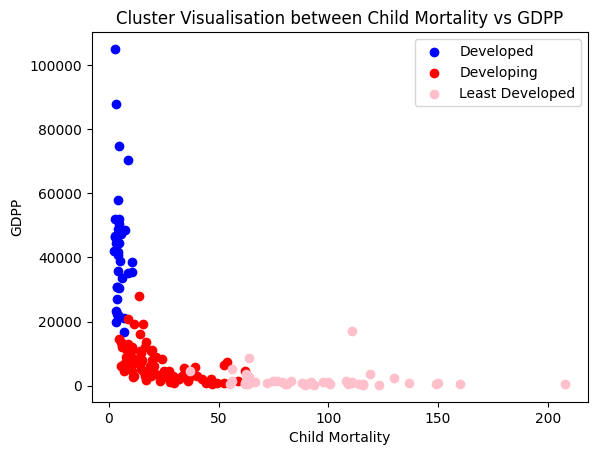

In [22]:
# Visualisation of clusters: child mortality vs gdpp
cluster_data = country[country['Cluster'] == 0]
cluster_data1 = country[country['Cluster'] == 1]
cluster_data2 = country[country['Cluster'] == 2]
plt.scatter(cluster_data1['child_mort'], cluster_data1['gdpp'], color = 'blue', label = 'Developed')
plt.scatter(cluster_data['child_mort'], cluster_data['gdpp'], color = 'red', label = 'Developing')
plt.scatter(cluster_data2['child_mort'], cluster_data2['gdpp'], color = 'pink', label = 'Least Developed')
plt.xlabel('Child Mortality')
plt.ylabel('GDPP')
plt.title('Cluster Visualisation between Child Mortality vs GDPP')
plt.legend()
plt.show()

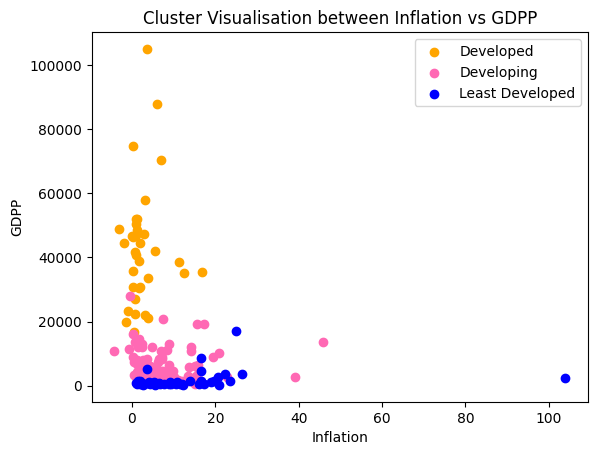

In [23]:
# Visualisation of clusters: inflation vs gdpp
cluster_data = country[country['Cluster'] == 0]
cluster_data1 = country[country['Cluster'] == 1]
cluster_data2 = country[country['Cluster'] == 2]
plt.scatter(cluster_data1['inflation'], cluster_data1['gdpp'], color = 'orange', label = 'Developed')
plt.scatter(cluster_data['inflation'], cluster_data['gdpp'], color = 'hotpink', label = 'Developing')
plt.scatter(cluster_data2['inflation'], cluster_data2['gdpp'], color = 'blue', label = 'Least Developed')
plt.xlabel('Inflation')
plt.ylabel('GDPP')
plt.title('Cluster Visualisation between Inflation vs GDPP')
plt.legend()
plt.show()

## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**

Looking at the Cluster Visualisation between Child Mortality vs GDPP, we can see that the developed countries are represented by blue plots; this shows that their economies are functioning well because they have low child mortality rates and high GDPP. 
The developing countries are represented by red plots; their GDPP is significantly lower than the developed countries, and their child mortality rate is slightly higher.
With high rates of child mortality and a very low GDPP, the final plot (the pink plot) shows that it is the least developed and the country is not doing well.

In the Cluster Visualisation between Inflation vs GDPP, the developed countries are shown by the orange plot; this shows that their GDPP is high and their inflation rate is low, which lowers their cost of living and makes life a little more affordable. 
In this visualisation developing countries with a lower GDPP are shown by a pink plot. These countries have slightly higher inflation than other countries, which can have a negative effect on their economy. 
The blue plot displays both high inflation and low GDPP. High inflation shows that goods prices rise quickly within days or weeks which discourages long-term planning and causes the country's currency to quickly decrease. Low GDPP shows that living expenses are high for the economy.